In [1]:
%run ../../base-notebook.ipynb

2023-06-14 11:09:57 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt [746/746] -> "../../ext/contents.txt" [1]
2023-06-14 11:09:57 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py [8266/8266] -> "../../ext/ml_callback.py" [1]
2023-06-14 11:09:57 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_internal.py [3032/3032] -> "../../ext/ml_internal.py" [1]
2023-06-14 11:09:58 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py [2552/2552] -> "../../ext/ml_io.py" [1]
2023-06-14 11:09:58 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_layer.py [8838/8838] -> "../../ext/ml_layer.py" [1]
2023-06-14 11:09:58 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_plot.py [22023/22023] -> "../../ext/ml_plot.py" [1]
2023-06-14 11:09:58 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py [2085/2085] -> "../../ext/ml_util.py" [1]
2023-06-1

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [6]:
import sys

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_plot as mlp
import ext.ml_util as mlu
import ext.ml_data as mld
import ext.ml_view as mlv
import ext.ml_internal as mlint
import ext.ml_transformer as mlt

import opendatasets as od
import tensorflow as tf
import pandas as pd
import datetime
import shap

from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.losses import mean_absolute_error
from keras.callbacks import TensorBoard
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config

/Users/sodeso/miniforge3/envs/ml/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/sodeso/miniforge3/envs/ml/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

# Configure mixed-precision so we can improve the performance

In [ ]:
mlu.set_mixed_precision_policy_for_gpu()

# Download the dataset from Kaggle (kaggle.json API key neccesary)

In [60]:
# Download the dogs and cats dataset
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/tugberkkaran/used-car-listings-features-and-prices-carscom/download?datasetVersionNumber=1",
                           data_dir="./data")

Skipping, found downloaded files in "./data/used-car-listings-features-and-prices-carscom" (use force=True to force download)


# CSV File Definition

let's first get an overview of the definition of all the columns:

* brand: Brand of the car.
* model: Model of the car.
* year: Year of production of the car.
* mileage: Mileage of the car.
* engine: Information about the car's engine.
* engine_size: Size of the car's engine.
* transmission: Type of transmission of the car.
* automatic_transmission: A binary value indicating the presence of automatic transmission (1: Yes, 0: No).
* fuel_type: Fuel type of the car.
* drivetrain: Drivetrain type of the car.
* min_mpg: Minimum fuel efficiency of the car.
* max_mpg: Maximum fuel efficiency of the car.
* damaged: A binary value indicating the presence of damage in the car (1: Yes, 0: No).
* first_owner: Is the car a 1-owner vehicle? (1: Yes, 0: No).
* personal_using: Is the car for personal use only? (1: Yes, 0: No).
* turbo: A binary value indicating the presence of a turbocharger in the car (1: Yes, 0: No).
* alloy_wheels: Are there alloy wheels on the car? (1: Yes, 0: No).
* adaptive_cruise_control: A binary value indicating the presence of adaptive cruise control (1: Yes, 0: No).
* navigation_system: A binary value indicating the presence of a navigation system (1: Yes, 0: No).
* power_liftgate: A binary value indicating the presence of a power liftgate (1: Yes, 0: No).
* backup_camera: A binary value indicating the presence of a backup camera (1: Yes, 0: No).
* keyless_start: A binary value indicating the presence of keyless start system (1: Yes, 0: No).
* remote_start: A binary value indicating the presence of a remote start system (1: Yes, 0: No).
* sunroof/moonroof: A binary value indicating the presence of a sunroof/moonroof (1: Yes, 0: No).
* automatic_emergency_braking: A binary value indicating the presence of automatic emergency braking system (1: Yes, 0: No).
* stability_control: A binary value indicating the presence of stability control system (1: Yes, 0: No).
* leather_seats: Are there leather seats in the car? (1: Yes, 0: No).
* memory_seat: Are there memory seats in the car? (1: Yes, 0: No).
* third_row_seating: A binary value indicating the presence of third row seating (1: Yes, 0: No).
* apple_car_play/android_auto: A binary value indicating the presence of Apple CarPlay / Android Auto integration (1: Yes, 0: No).
* bluetooth: A binary value indicating the presence of Bluetooth connectivity (1: Yes, 0: No).
* usb_port: A binary value indicating the presence of USB ports (1: Yes, 0: No).
* heated_seats: Are there heated seats in the car? (1: Yes, 0: No).
* interior_color: Interior color of the car.
* exterior_color: Exterior color of the car.
* price: Price of the car. This feature is the target feature of this dataset.

# Inspect the contents of the downloaded dataset

In [3]:
train_csv = "./data/used-car-listings-features-and-prices-carscom/train.csv"
test_csv = "./data/used-car-listings-features-and-prices-carscom/test.csv"

In [7]:
# Load the training data
train_csv = pd.read_csv(train_csv)
train_csv[:5]

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,price
0,Mazda,CX-9 Touring,2022.0,6580.0,2.5L I4 16V GDI DOHC Turbo,2.5,6-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,Black,Snowflake White Pearl,36789
1,Alfa,Romeo Stelvio 4DR SUV AWD,2018.0,62717.0,Twin Turbo Premium Unleaded V-6 2.9 L/176,2.9,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,Black,Rosso Competizione Tri-Coat,39993
2,Chevrolet,Silverado 1500 Limited LT,2022.0,15463.0,5.3L V8 16V GDI OHV,5.3,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Jet Black,Silver Ice Metallic,46986
3,Land,Rover Range Rover P400 SE,2022.0,1281.0,3.0L I6 24V GDI DOHC Turbo,3.0,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,Ebony,Fuji White,141999
4,Mitsubishi,Outlander Sport 2.0 SE,2021.0,36727.0,2.0L I4 16V MPFI DOHC,2.0,Automatic CVT,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,Black,White,21595


# Inspect column attributes like type, null / not-null columns, distribution, outliers, etc...

In [44]:
mld.describe_dataframe(train_csv)

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,19107,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model,object,19107,2,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,year,float64,19107,2,59,2017.77,5.00,2002.78,2032.76,1962.0,2016.0,2019.0,2021.0,2024.0
3,mileage,float64,19107,2,17412,47947.09,38285.06,-66908.10,162802.27,0.0,19307.0,39141.0,68431.5,383614.0
4,engine,object,19062,47,1163,47947.09,38285.06,-66908.10,162802.27,0.0,19307.0,39141.0,68431.5,383614.0
5,engine_size,float64,17860,1249,62,2.97,5.48,-13.46,19.41,0.0,2.0,2.5,3.5,390.0
6,transmission,object,19004,105,189,2.97,5.48,-13.46,19.41,0.0,2.0,2.5,3.5,390.0
7,automatic_transmission,float64,19107,2,2,0.92,0.28,0.09,1.74,0.0,1.0,1.0,1.0,1.0
8,fuel_type,object,19107,2,10,0.92,0.28,0.09,1.74,0.0,1.0,1.0,1.0,1.0
9,drivetrain,object,19107,2,5,0.92,0.28,0.09,1.74,0.0,1.0,1.0,1.0,1.0


# Column brand

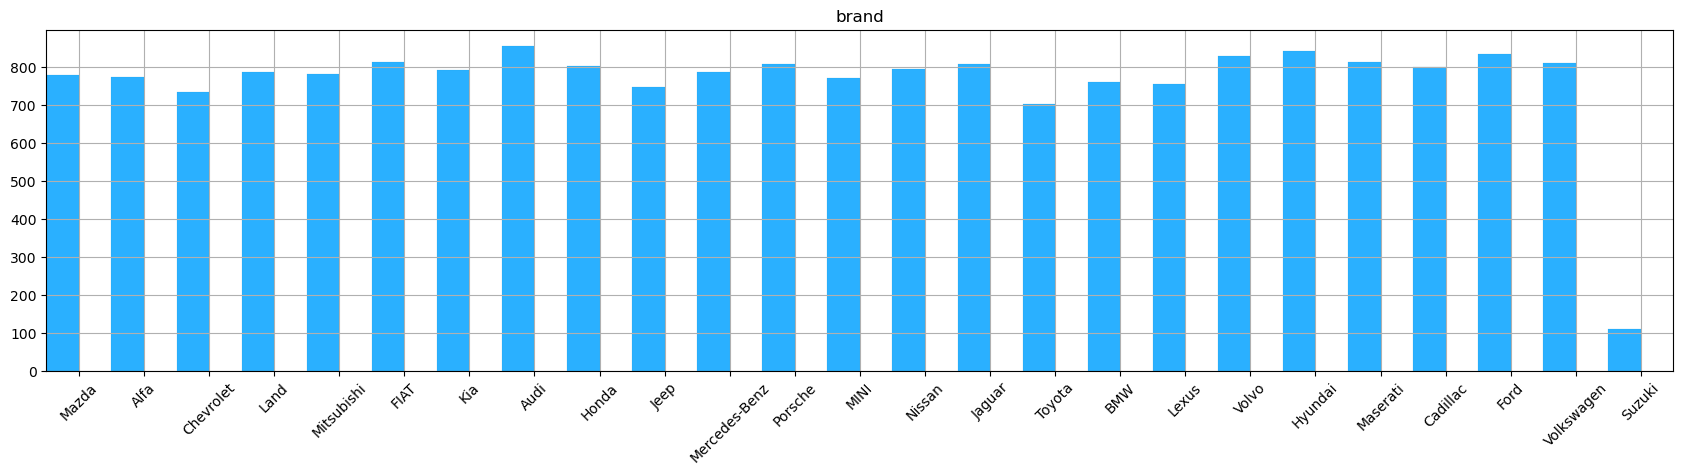

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,19107,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="brand")
d = mld.describe_dataframe(train_csv, column_names="brand")
d

# Column model

In [10]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="model")
d = mld.describe_dataframe(train_csv, column_names="model")
d

Column 'model' is not visualized, the number of nunique values (3498) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,model,object,19107,2,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Column year

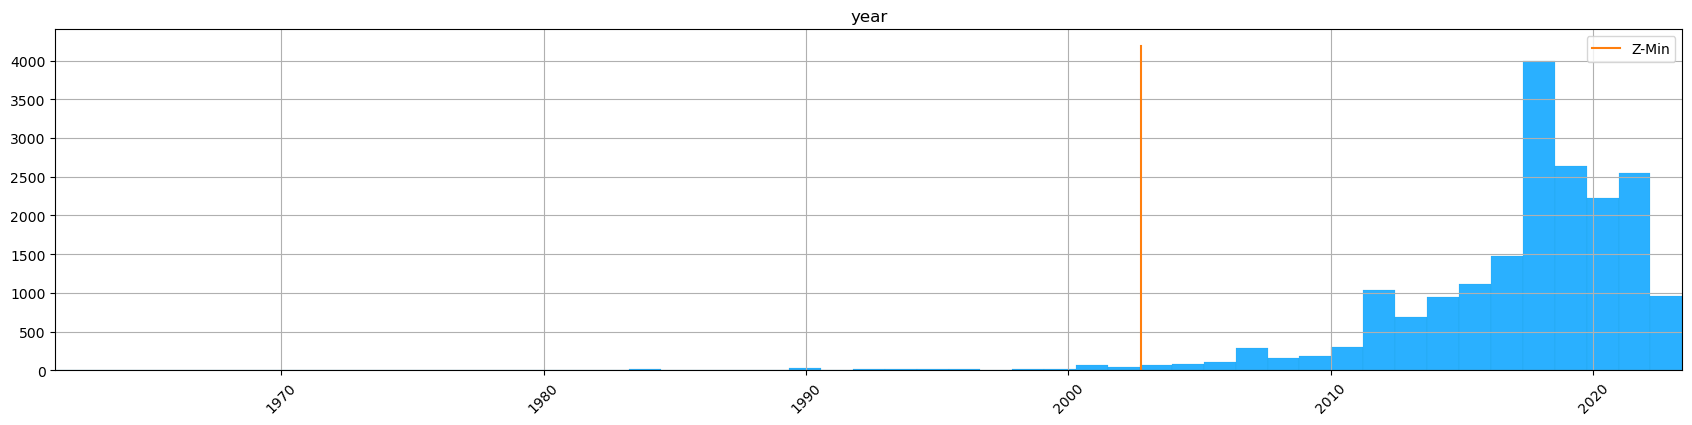

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,year,float64,19107,2,59,2017.77,5.0,2002.78,2032.76,1962.0,2016.0,2019.0,2021.0,2024.0


In [20]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="year")
d = mld.describe_dataframe(train_csv, column_names="year")
d

# Column mileage

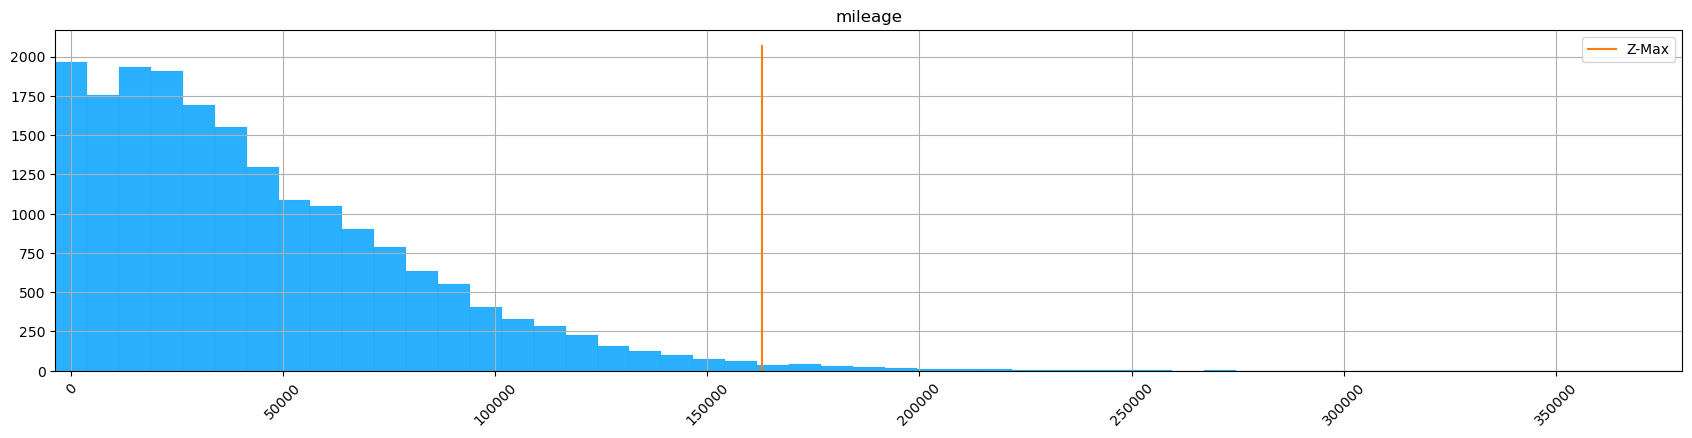

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,mileage,float64,19107,2,17412,47947.09,38285.06,-66908.1,162802.27,0.0,19307.0,39141.0,68431.5,383614.0


In [19]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="mileage")
d = mld.describe_dataframe(train_csv, column_names="mileage")
d

# Column engine

In [29]:
d = mld.describe_dataframe(train_csv, column_names="engine")
d

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,engine,object,19062,47,1163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Column engine_size

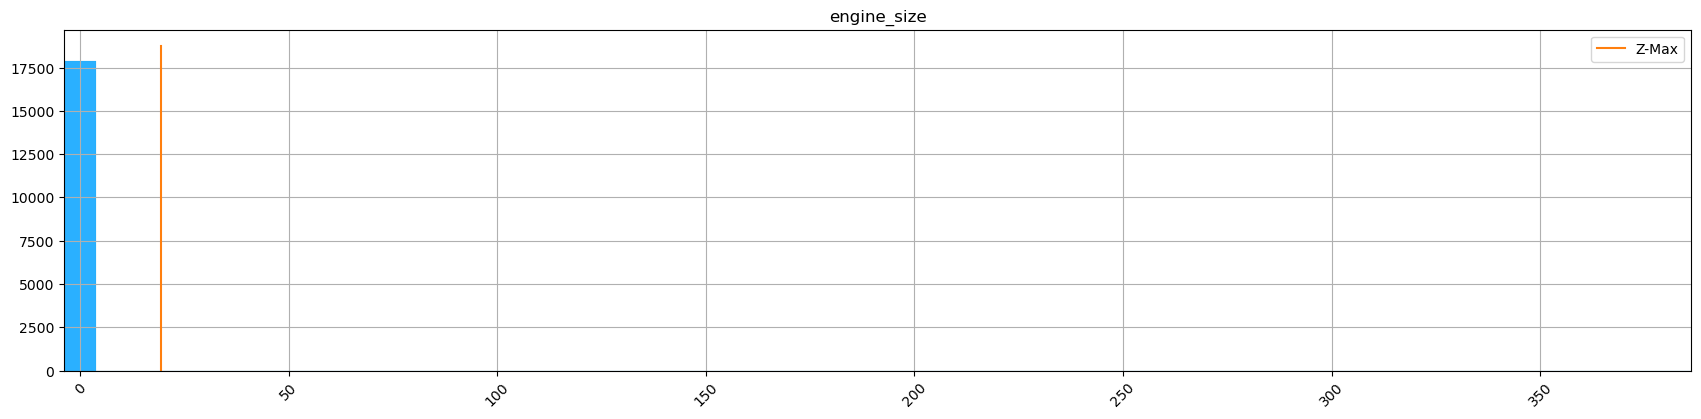

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,engine_size,float64,17860,1249,62,2.97,5.48,-13.46,19.41,0.0,2.0,2.5,3.5,390.0


In [24]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="engine_size")
d = mld.describe_dataframe(train_csv, column_names="engine_size")
d

# Column transmission

In [28]:
d = mld.describe_dataframe(train_csv, column_names="transmission")
d

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,transmission,object,19004,105,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Column automatic_transmission

In [33]:
d = mld.describe_dataframe(train_csv, column_names="automatic_transmission")
d

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,automatic_transmission,float64,19107,2,2,0.92,0.28,0.09,1.74,0.0,1.0,1.0,1.0,1.0


# Column fuel_type

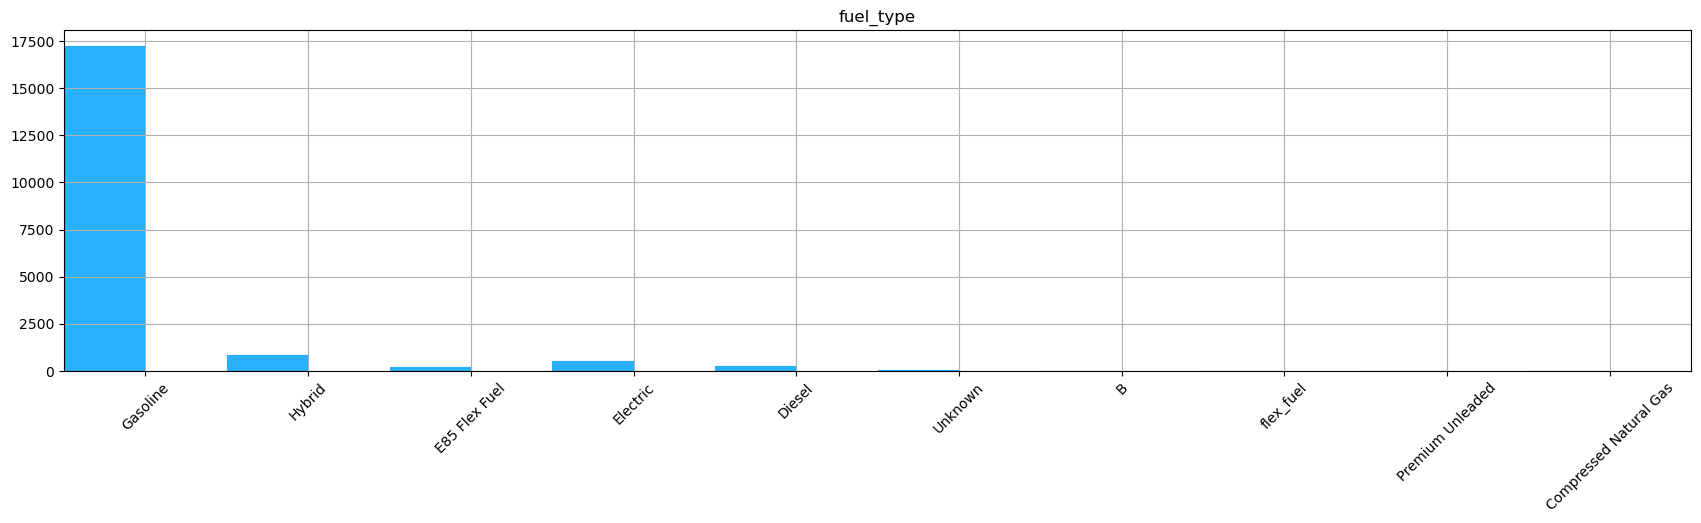

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,fuel_type,object,19107,2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="fuel_type")
d = mld.describe_dataframe(train_csv, column_names="fuel_type")
d

# Column drivetrain

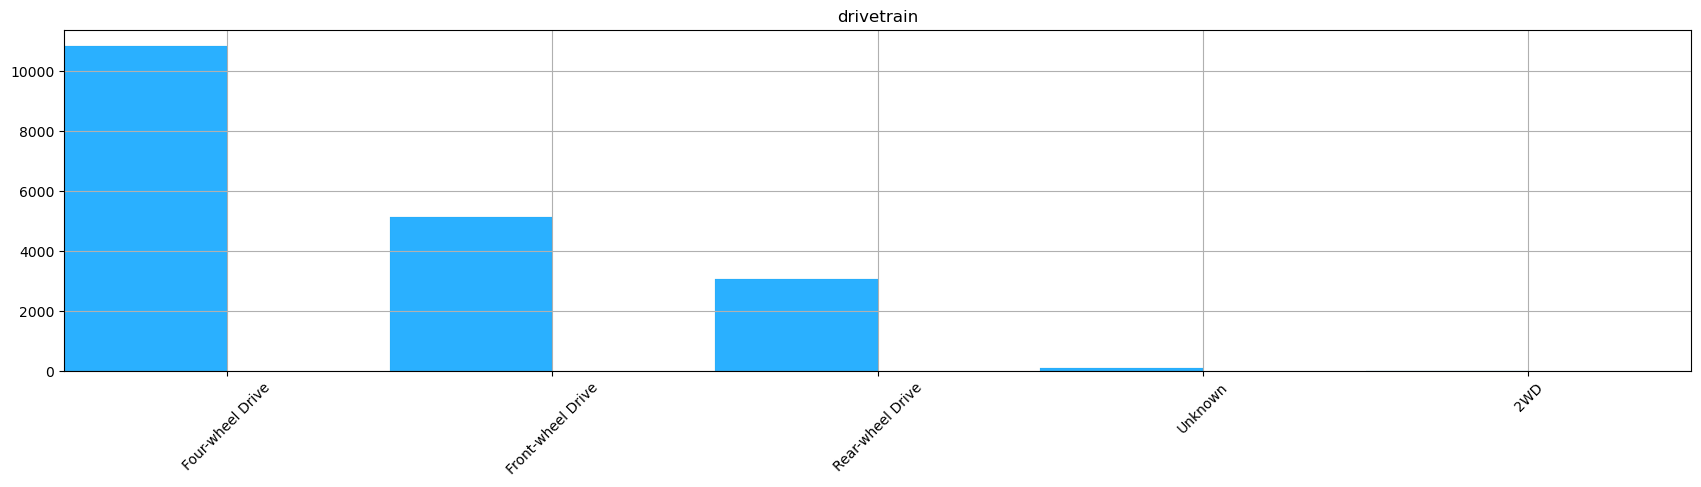

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,drivetrain,object,19107,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="drivetrain")
d = mld.describe_dataframe(train_csv, column_names="drivetrain")
d

# Column min_mpg

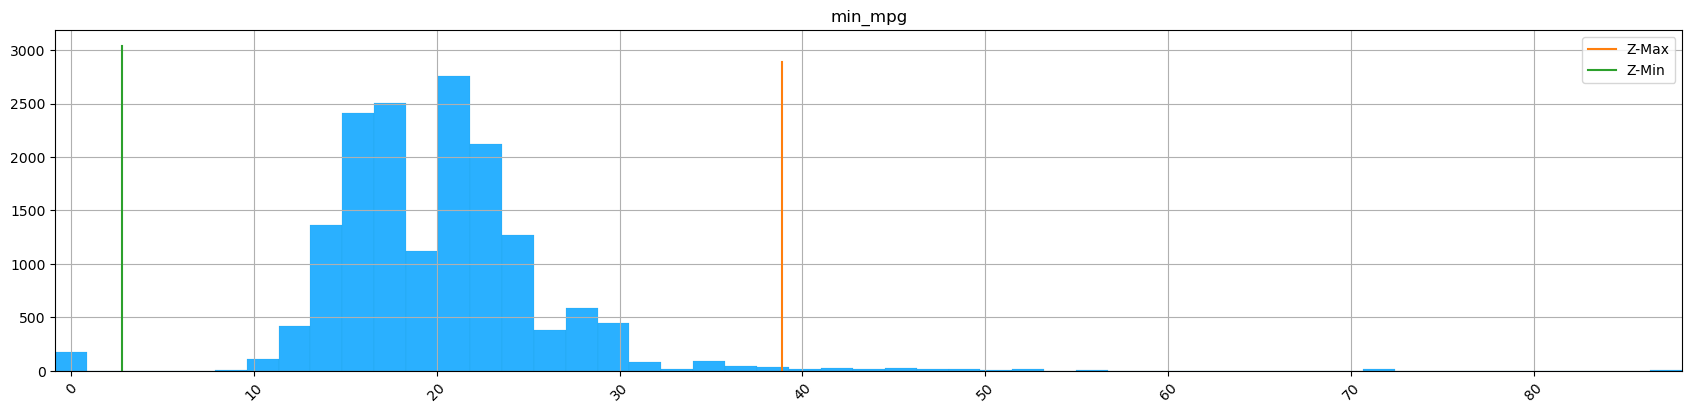

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,min_mpg,float64,16103,3006,53,20.83,6.02,2.77,38.88,0.0,17.0,20.0,24.0,89.0


In [36]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="min_mpg")
d = mld.describe_dataframe(train_csv, column_names="min_mpg")
d

# Column max_mpg

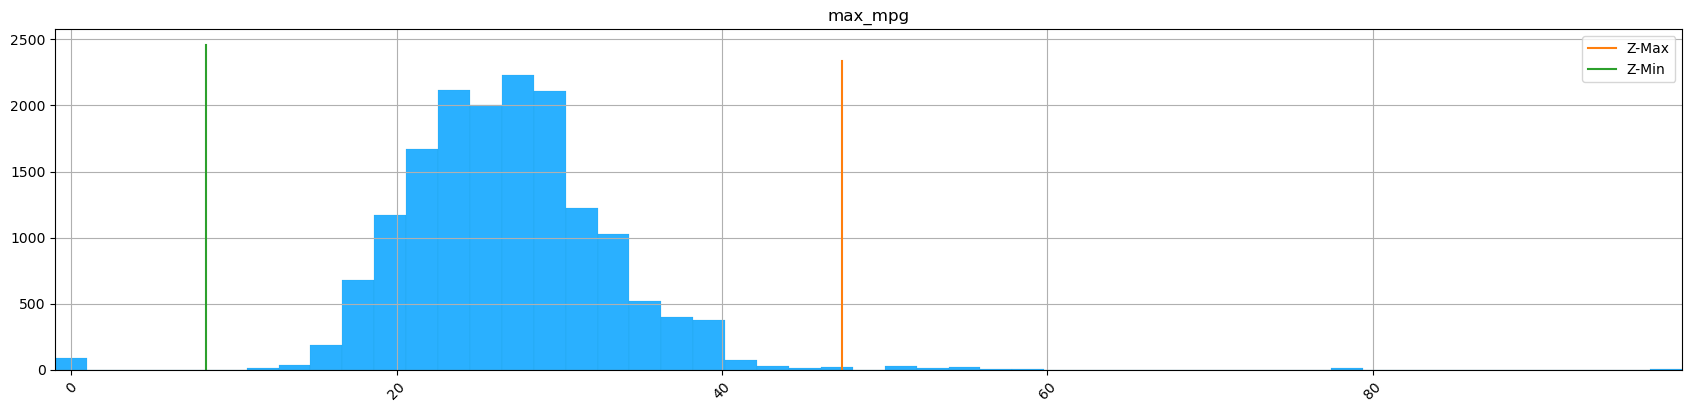

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,max_mpg,float64,16103,3006,57,27.82,6.51,8.28,47.36,0.0,24.0,28.0,31.0,100.0


In [37]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="max_mpg")
d = mld.describe_dataframe(train_csv, column_names="max_mpg")
d

# Column damaged, first_owner, personal_using, turbo, alloy_wheels, adaptive_cruise_control, navigation_system, power_liftgate, backup_camera, keyless_start, sunroof/moonroof, automatic_emergency_breaking, stability_control, leather_seat, memory_seat, third_row_seating, apple_car_play/android_auto, bluetooth, sub_port, heated_seats

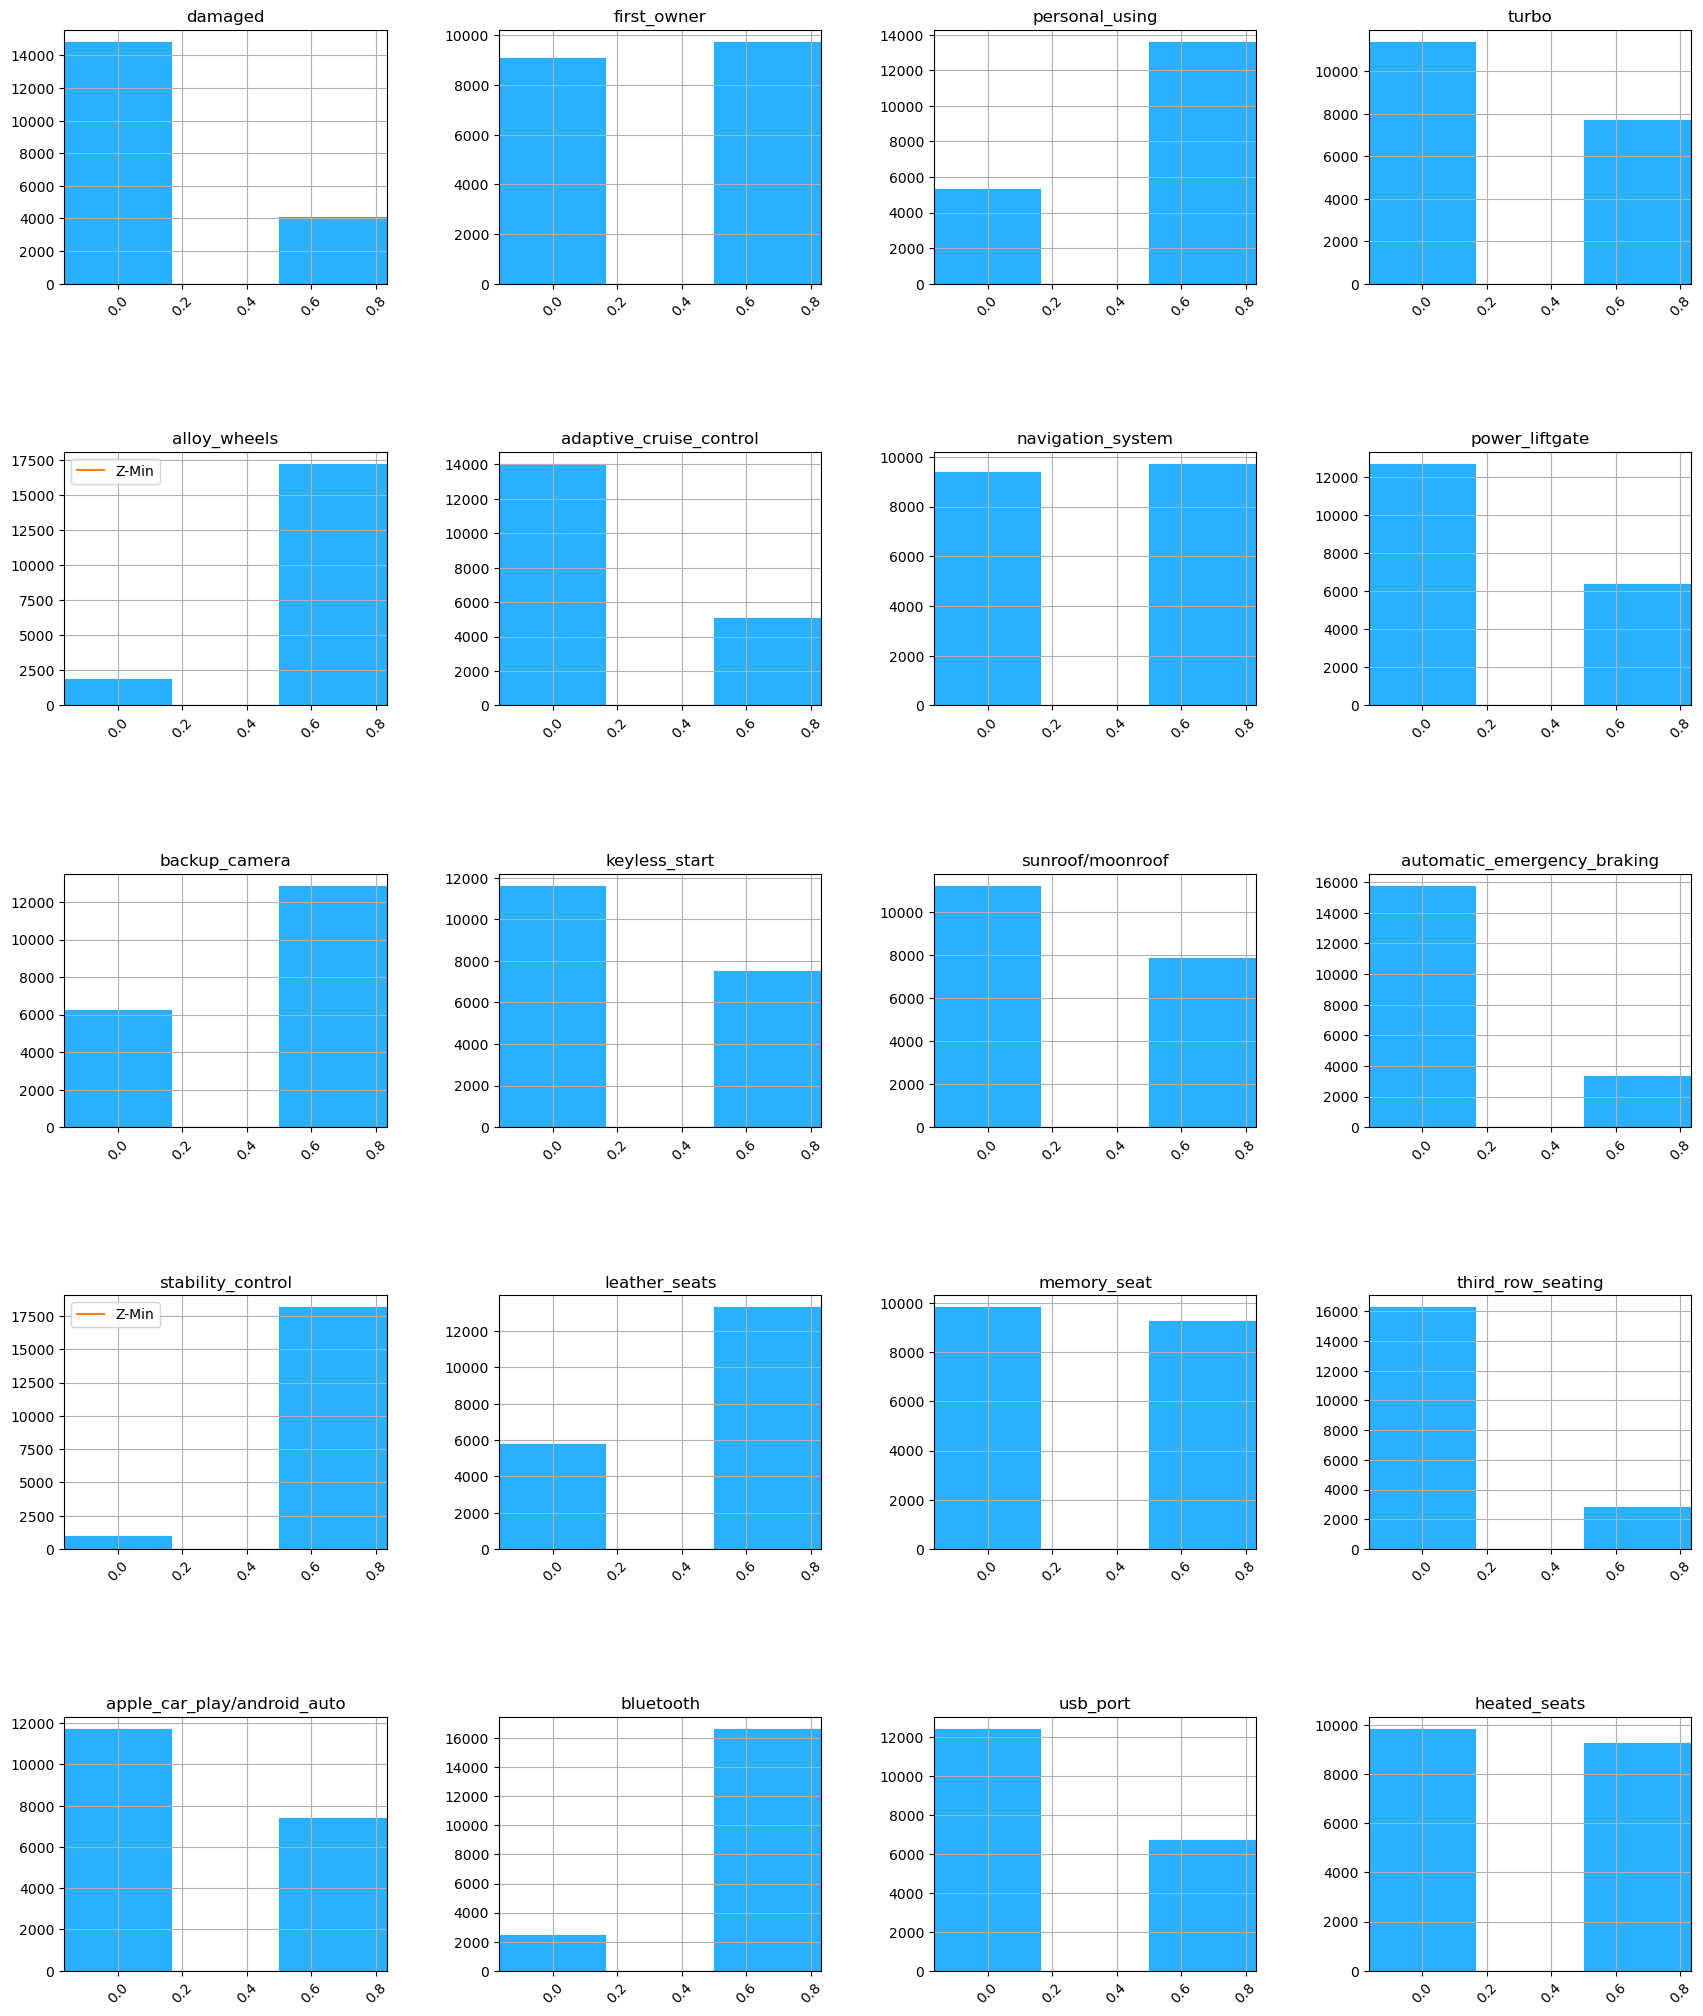

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,damaged,float64,18940,169,2,0.22,0.41,-1.02,1.45,0.0,0.0,0.0,0.0,1.0
1,first_owner,float64,18803,306,2,0.52,0.50,-0.98,2.02,0.0,0.0,1.0,1.0,1.0
2,personal_using,float64,18920,189,2,0.72,0.45,-0.63,2.07,0.0,0.0,1.0,1.0,1.0
3,turbo,float64,19107,2,2,0.40,0.49,-1.07,1.88,0.0,0.0,0.0,1.0,1.0
4,alloy_wheels,float64,19107,2,2,0.90,0.30,0.01,1.80,0.0,1.0,1.0,1.0,1.0
5,adaptive_cruise_control,float64,19107,2,2,0.27,0.44,-1.06,1.59,0.0,0.0,0.0,1.0,1.0
6,navigation_system,float64,19107,2,2,0.51,0.50,-0.99,2.01,0.0,0.0,1.0,1.0,1.0
7,power_liftgate,float64,19107,2,2,0.33,0.47,-1.08,1.75,0.0,0.0,0.0,1.0,1.0
8,backup_camera,float64,19107,2,2,0.67,0.47,-0.73,2.08,0.0,0.0,1.0,1.0,1.0
9,keyless_start,float64,19107,2,2,0.39,0.49,-1.07,1.86,0.0,0.0,0.0,1.0,1.0


In [56]:
column_names = ["damaged", "first_owner", "personal_using", "turbo", "alloy_wheels", "adaptive_cruise_control", "navigation_system", "power_liftgate", "backup_camera", "keyless_start", "sunroof/moonroof", "automatic_emergency_braking", "stability_control", "leather_seats", "memory_seat", "third_row_seating", "apple_car_play/android_auto", "bluetooth", "usb_port", "heated_seats"]

mlp.plot_histogram_from_dataframe(train_csv, column_names=column_names, min_nunique=0, cols=4)
d = mld.describe_dataframe(train_csv, column_names=column_names)
d

# Column interior_color

# Column exterior_color

# Column price

In [ ]:
mld.describe_dataframe(train_csv)

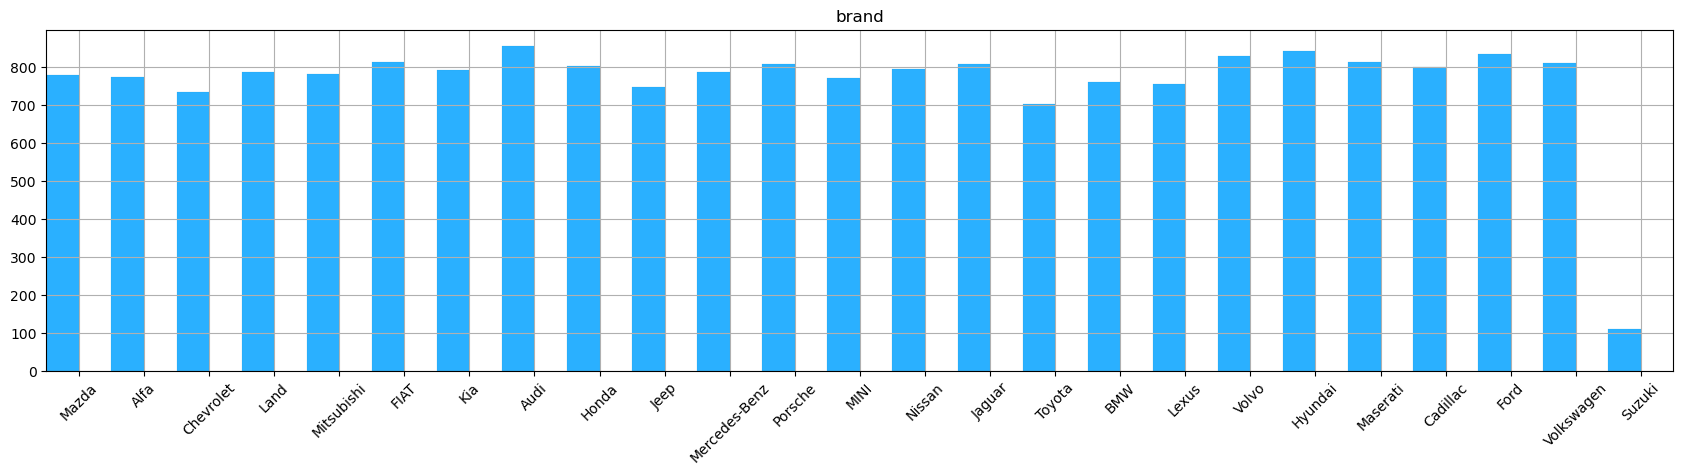

In [34]:
mlp.plot_histogram_from_dataframe(dataframe=train_csv, column_names="brand", min_nunique=3, max_nunique=62, cols=2, verbose=0)

In [116]:
train_csv[train_csv["brand"] == "Mazda"]

Column 'model' is not visualized, the number of nunique values (3498) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 19107


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,model,object,19107,0,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Initial observations

It seems there are some NULL values in the columns, let's see if we can get rit of those.

In [ ]:
fuel_pipeline = Pipeline(steps=[
    ("fuel_scaler", OneHotEncoder())
])

set_config(transform_output="default")
ct = make_column_transformer(
    (fuel_pipeline, ["fuel_type"]),
    remainder="drop"
)

train_csv_pre = ct.fit_transform(train_csv)
train_csv_pre.todense()[:10]